# Visualizing what convnets learn: Cats and dogs prediction 실습

### 201632230 컴퓨터공학과 이다은

### 2020. 06. 24

<br/>

## 0. 실습 리포트 참고사항

* 1-1~1-4는 각 10장의 cats, dogs 이미지 prediction과 원본 이미지에 heatmap을 추가한 결과에 대한 내용이다.
* 2-1~2-4는 합성곱 기반 층의 마지막 layer의 전체 filter 이미지 출력에 대한 내용이다.

<br/>

# Cats and Dogs Prediction

## 1-1. 실습문제 풀이방법

    1. 각 10장의 cats, dogs 이미지를 지인과 구글을 통해 수집했다.
    2. 이미지 prediction을 위해 미리 정의해둔 cats_and_dogs_small_2 모델을 이용했다.
    3. cats, dogs의 종을 분류하고 원본 이미지에 heatmap을 추가할 때는 VGG16 모델을 사용했다.

## 1-2. 문서화된 소스코드 및 실행 결과

In [1]:
# cats_and_dogs_small_2 모델 로드

from keras.models import load_model

model = load_model('cats_and_dogs_small_2.h5')

model.summary()

Using TensorFlow backend.


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 15, 15, 128)      

In [13]:
# VGG16 모델 로드

from keras.applications.vgg16 import VGG16

modelVGG = VGG16(weights='imagenet')

modelVGG.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### 개

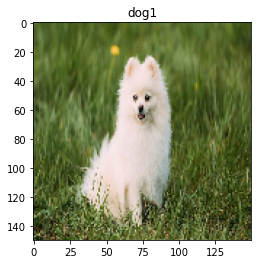

예측 결과 값: [[0.9962016]]
개 종류 예측: [('n02112018', 'Pomeranian', 0.505017), ('n02111889', 'Samoyed', 0.29471907), ('n02086910', 'papillon', 0.039199643)]


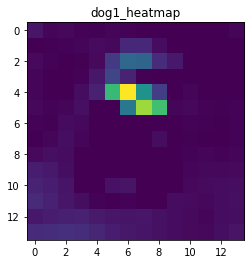

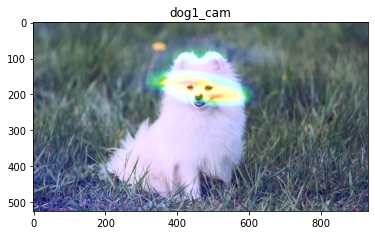

In [64]:
# dog 1

from keras.preprocessing import image
from keras import models
import numpy as np
import matplotlib.pyplot as plt

# 원본 이미지 로드
img_path = './datasets/cats_and_dogs_small/test/dog1.jpg'

# 이미지 prediction
img1 = image.load_img(img_path, target_size=(150, 150))
img_tensor1 = image.img_to_array(img1)
img_tensor1 = np.expand_dims(img_tensor1, axis=0)
img_tensor1 /= 255.

prediction1 = model.predict(img_tensor1)

# 개 종류 prediction
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions

img2 = image.load_img(img_path, target_size=(224, 224))
img_tensor2 = image.img_to_array(img2)
img_tensor2 = np.expand_dims(img_tensor2, axis=0)
img_tensor2 = preprocess_input(img_tensor2)

prediction2 = modelVGG.predict(img_tensor2)

# heatmap을 위한 Grad-CAM 알고리즘 설정
dog_output = modelVGG.output[:, np.argmax(prediction2[0])]

last_conv_layer = modelVGG.get_layer('block5_conv3')

grads = K.gradients(dog_output, last_conv_layer.output)[0]

pooled_grads = K.mean(grads, axis=(0, 1, 2))

iterate = K.function([modelVGG.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([img_tensor2])

for i in range(0, 512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap1 = np.mean(conv_layer_output_value, axis=-1)

# heatmap 후처리
heatmap1 = np.maximum(heatmap1, 0)
heatmap1 /= np.max(heatmap1)

# 원본 이미지에 heatmap 추가
import cv2

img = cv2.imread(img_path)

heatmap2 = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap2 = np.uint8(255 * heatmap2)
heatmap2 = cv2.applyColorMap(heatmap2, cv2.COLORMAP_JET)

superimposed_img = heatmap2 * 0.4 + img

cv2.imwrite('./datasets/cats_and_dogs_small/test/dog1_cam.jpg', superimposed_img)

# dog 1 결과 출력

# 원본 이미지에 heatmap 추가된 이미지 로드
img_heatmap = plt.imread('./datasets/cats_and_dogs_small/test/dog1_cam.jpg')

# 원본 이미지
plt.title('dog1')
plt.imshow(img1)
plt.show()

# 이미지 prediction
print('예측 결과 값:', prediction1)

# 개 종류 prediction
print('개 종류 예측:', decode_predictions(prediction2, top=3)[0])

# heatmap
plt.title('dog1_heatmap')
plt.imshow(heatmap1)
plt.show()

# 원본 이미지에 heatmap 추가
plt.title('dog1_cam')
plt.imshow(img_heatmap)
plt.show()

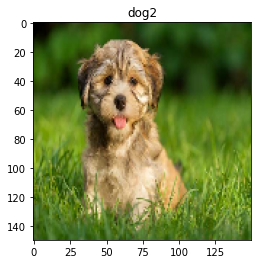

예측 결과 값: [[0.99993944]]
개 종류 예측: [('n02094114', 'Norfolk_terrier', 0.38087955), ('n02096437', 'Dandie_Dinmont', 0.25805786), ('n02097474', 'Tibetan_terrier', 0.09455315)]


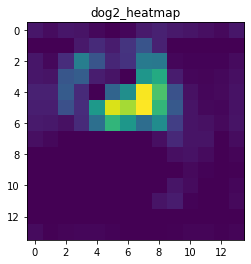

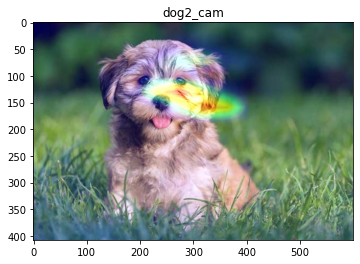

In [66]:
# dog 2

# 원본 이미지 로드
img_path = './datasets/cats_and_dogs_small/test/dog2.jpg'

# 이미지 prediction
img1 = image.load_img(img_path, target_size=(150, 150))
img_tensor1 = image.img_to_array(img1)
img_tensor1 = np.expand_dims(img_tensor1, axis=0)
img_tensor1 /= 255.

prediction1 = model.predict(img_tensor1)

# 개 종류 prediction
img2 = image.load_img(img_path, target_size=(224, 224))
img_tensor2 = image.img_to_array(img2)
img_tensor2 = np.expand_dims(img_tensor2, axis=0)
img_tensor2 = preprocess_input(img_tensor2)

prediction2 = modelVGG.predict(img_tensor2)

# heatmap을 위한 Grad-CAM 알고리즘 설정
dog_output = modelVGG.output[:, np.argmax(prediction2[0])]

last_conv_layer = modelVGG.get_layer('block5_conv3')

grads = K.gradients(dog_output, last_conv_layer.output)[0]

pooled_grads = K.mean(grads, axis=(0, 1, 2))

iterate = K.function([modelVGG.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([img_tensor2])

for i in range(0, 512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap1 = np.mean(conv_layer_output_value, axis=-1)

# heatmap 후처리
heatmap1 = np.maximum(heatmap1, 0)
heatmap1 /= np.max(heatmap1)

# 원본 이미지에 heatmap 추가
img = cv2.imread(img_path)

heatmap2 = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap2 = np.uint8(255 * heatmap2)
heatmap2 = cv2.applyColorMap(heatmap2, cv2.COLORMAP_JET)

superimposed_img = heatmap2 * 0.4 + img

cv2.imwrite('./datasets/cats_and_dogs_small/test/dog2_cam.jpg', superimposed_img)

# dog 1 결과 출력

# 원본 이미지에 heatmap 추가된 이미지 로드
img_heatmap = plt.imread('./datasets/cats_and_dogs_small/test/dog2_cam.jpg')

# 원본 이미지
plt.title('dog2')
plt.imshow(img1)
plt.show()

# 이미지 prediction
print('예측 결과 값:', prediction1)

# 개 종류 prediction
print('개 종류 예측:', decode_predictions(prediction2, top=3)[0])

# heatmap
plt.title('dog2_heatmap')
plt.imshow(heatmap1)
plt.show()

# 원본 이미지에 heatmap 추가
plt.title('dog2_cam')
plt.imshow(img_heatmap)
plt.show()

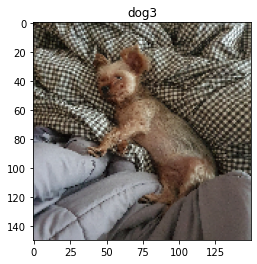

예측 결과 값: [[0.7514469]]
개 종류 예측: [('n02085620', 'Chihuahua', 0.83075374), ('n02094258', 'Norwich_terrier', 0.027281636), ('n02124075', 'Egyptian_cat', 0.016408125)]


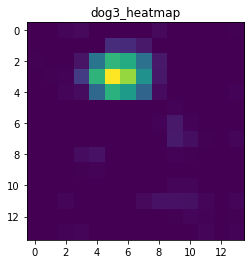

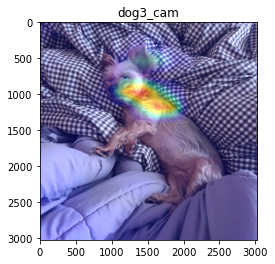

In [67]:
# dog 3

# 원본 이미지 로드
img_path = './datasets/cats_and_dogs_small/test/dog3.jpg'

# 이미지 prediction
img1 = image.load_img(img_path, target_size=(150, 150))
img_tensor1 = image.img_to_array(img1)
img_tensor1 = np.expand_dims(img_tensor1, axis=0)
img_tensor1 /= 255.

prediction1 = model.predict(img_tensor1)

# 개 종류 prediction
img2 = image.load_img(img_path, target_size=(224, 224))
img_tensor2 = image.img_to_array(img2)
img_tensor2 = np.expand_dims(img_tensor2, axis=0)
img_tensor2 = preprocess_input(img_tensor2)

prediction2 = modelVGG.predict(img_tensor2)

# heatmap을 위한 Grad-CAM 알고리즘 설정
dog_output = modelVGG.output[:, np.argmax(prediction2[0])]

last_conv_layer = modelVGG.get_layer('block5_conv3')

grads = K.gradients(dog_output, last_conv_layer.output)[0]

pooled_grads = K.mean(grads, axis=(0, 1, 2))

iterate = K.function([modelVGG.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([img_tensor2])

for i in range(0, 512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap1 = np.mean(conv_layer_output_value, axis=-1)

# heatmap 후처리
heatmap1 = np.maximum(heatmap1, 0)
heatmap1 /= np.max(heatmap1)

# 원본 이미지에 heatmap 추가
img = cv2.imread(img_path)

heatmap2 = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap2 = np.uint8(255 * heatmap2)
heatmap2 = cv2.applyColorMap(heatmap2, cv2.COLORMAP_JET)

superimposed_img = heatmap2 * 0.4 + img

cv2.imwrite('./datasets/cats_and_dogs_small/test/dog3_cam.jpg', superimposed_img)

# dog 1 결과 출력

# 원본 이미지에 heatmap 추가된 이미지 로드
img_heatmap = plt.imread('./datasets/cats_and_dogs_small/test/dog3_cam.jpg')

# 원본 이미지
plt.title('dog3')
plt.imshow(img1)
plt.show()

# 이미지 prediction
print('예측 결과 값:', prediction1)

# 개 종류 prediction
print('개 종류 예측:', decode_predictions(prediction2, top=3)[0])

# heatmap
plt.title('dog3_heatmap')
plt.imshow(heatmap1)
plt.show()

# 원본 이미지에 heatmap 추가
plt.title('dog3_cam')
plt.imshow(img_heatmap)
plt.show()

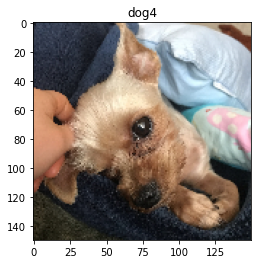

예측 결과 값: [[0.99413717]]
개 종류 예측: [('n02094433', 'Yorkshire_terrier', 0.23870899), ('n02085620', 'Chihuahua', 0.21141124), ('n02096294', 'Australian_terrier', 0.18557072)]


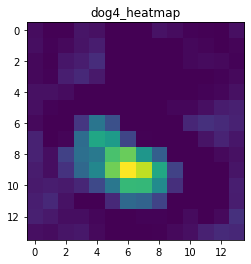

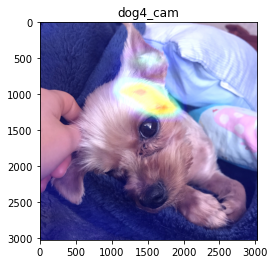

In [68]:
# dog 4

# 원본 이미지 로드
img_path = './datasets/cats_and_dogs_small/test/dog4.jpg'

# 이미지 prediction
img1 = image.load_img(img_path, target_size=(150, 150))
img_tensor1 = image.img_to_array(img1)
img_tensor1 = np.expand_dims(img_tensor1, axis=0)
img_tensor1 /= 255.

prediction1 = model.predict(img_tensor1)

# 개 종류 prediction
img2 = image.load_img(img_path, target_size=(224, 224))
img_tensor2 = image.img_to_array(img2)
img_tensor2 = np.expand_dims(img_tensor2, axis=0)
img_tensor2 = preprocess_input(img_tensor2)

prediction2 = modelVGG.predict(img_tensor2)

# heatmap을 위한 Grad-CAM 알고리즘 설정
dog_output = modelVGG.output[:, np.argmax(prediction2[0])]

last_conv_layer = modelVGG.get_layer('block5_conv3')

grads = K.gradients(dog_output, last_conv_layer.output)[0]

pooled_grads = K.mean(grads, axis=(0, 1, 2))

iterate = K.function([modelVGG.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([img_tensor2])

for i in range(0, 512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap1 = np.mean(conv_layer_output_value, axis=-1)

# heatmap 후처리
heatmap1 = np.maximum(heatmap1, 0)
heatmap1 /= np.max(heatmap1)

# 원본 이미지에 heatmap 추가
img = cv2.imread(img_path)

heatmap2 = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap2 = np.uint8(255 * heatmap2)
heatmap2 = cv2.applyColorMap(heatmap2, cv2.COLORMAP_JET)

superimposed_img = heatmap2 * 0.4 + img

cv2.imwrite('./datasets/cats_and_dogs_small/test/dog4_cam.jpg', superimposed_img)

# dog 1 결과 출력

# 원본 이미지에 heatmap 추가된 이미지 로드
img_heatmap = plt.imread('./datasets/cats_and_dogs_small/test/dog4_cam.jpg')

# 원본 이미지
plt.title('dog4')
plt.imshow(img1)
plt.show()

# 이미지 prediction
print('예측 결과 값:', prediction1)

# 개 종류 prediction
print('개 종류 예측:', decode_predictions(prediction2, top=3)[0])

# heatmap
plt.title('dog4_heatmap')
plt.imshow(heatmap1)
plt.show()

# 원본 이미지에 heatmap 추가
plt.title('dog4_cam')
plt.imshow(img_heatmap)
plt.show()

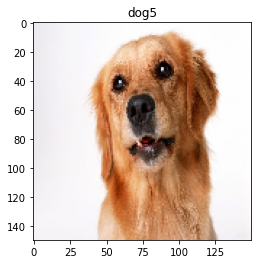

예측 결과 값: [[0.99999595]]
개 종류 예측: [('n02099601', 'golden_retriever', 0.9575875), ('n02100877', 'Irish_setter', 0.017634932), ('n04409515', 'tennis_ball', 0.0056569693)]


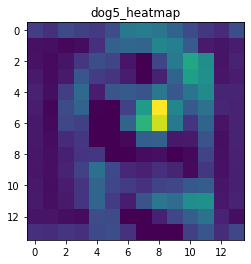

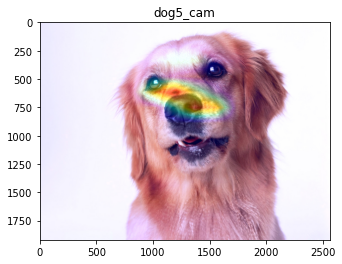

In [70]:
# dog 5

# 원본 이미지 로드
img_path = './datasets/cats_and_dogs_small/test/dog5.jpg'

# 이미지 prediction
img1 = image.load_img(img_path, target_size=(150, 150))
img_tensor1 = image.img_to_array(img1)
img_tensor1 = np.expand_dims(img_tensor1, axis=0)
img_tensor1 /= 255.

prediction1 = model.predict(img_tensor1)

# 개 종류 prediction
img2 = image.load_img(img_path, target_size=(224, 224))
img_tensor2 = image.img_to_array(img2)
img_tensor2 = np.expand_dims(img_tensor2, axis=0)
img_tensor2 = preprocess_input(img_tensor2)

prediction2 = modelVGG.predict(img_tensor2)

# heatmap을 위한 Grad-CAM 알고리즘 설정
dog_output = modelVGG.output[:, np.argmax(prediction2[0])]

last_conv_layer = modelVGG.get_layer('block5_conv3')

grads = K.gradients(dog_output, last_conv_layer.output)[0]

pooled_grads = K.mean(grads, axis=(0, 1, 2))

iterate = K.function([modelVGG.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([img_tensor2])

for i in range(0, 512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap1 = np.mean(conv_layer_output_value, axis=-1)

# heatmap 후처리
heatmap1 = np.maximum(heatmap1, 0)
heatmap1 /= np.max(heatmap1)

# 원본 이미지에 heatmap 추가
img = cv2.imread(img_path)

heatmap2 = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap2 = np.uint8(255 * heatmap2)
heatmap2 = cv2.applyColorMap(heatmap2, cv2.COLORMAP_JET)

superimposed_img = heatmap2 * 0.4 + img

cv2.imwrite('./datasets/cats_and_dogs_small/test/dog5_cam.jpg', superimposed_img)

# dog 1 결과 출력

# 원본 이미지에 heatmap 추가된 이미지 로드
img_heatmap = plt.imread('./datasets/cats_and_dogs_small/test/dog5_cam.jpg')

# 원본 이미지
plt.title('dog5')
plt.imshow(img1)
plt.show()

# 이미지 prediction
print('예측 결과 값:', prediction1)

# 개 종류 prediction
print('개 종류 예측:', decode_predictions(prediction2, top=3)[0])

# heatmap
plt.title('dog5_heatmap')
plt.imshow(heatmap1)
plt.show()

# 원본 이미지에 heatmap 추가
plt.title('dog5_cam')
plt.imshow(img_heatmap)
plt.show()

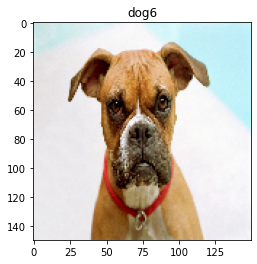

예측 결과 값: [[0.92187214]]
개 종류 예측: [('n02108089', 'boxer', 0.9571869), ('n02108422', 'bull_mastiff', 0.020625055), ('n02093428', 'American_Staffordshire_terrier', 0.020343052)]


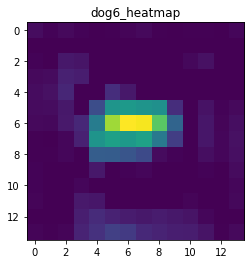

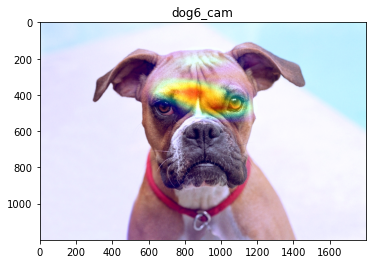

In [71]:
# dog 6

# 원본 이미지 로드
img_path = './datasets/cats_and_dogs_small/test/dog6.jpg'

# 이미지 prediction
img1 = image.load_img(img_path, target_size=(150, 150))
img_tensor1 = image.img_to_array(img1)
img_tensor1 = np.expand_dims(img_tensor1, axis=0)
img_tensor1 /= 255.

prediction1 = model.predict(img_tensor1)

# 개 종류 prediction
img2 = image.load_img(img_path, target_size=(224, 224))
img_tensor2 = image.img_to_array(img2)
img_tensor2 = np.expand_dims(img_tensor2, axis=0)
img_tensor2 = preprocess_input(img_tensor2)

prediction2 = modelVGG.predict(img_tensor2)

# heatmap을 위한 Grad-CAM 알고리즘 설정
dog_output = modelVGG.output[:, np.argmax(prediction2[0])]

last_conv_layer = modelVGG.get_layer('block5_conv3')

grads = K.gradients(dog_output, last_conv_layer.output)[0]

pooled_grads = K.mean(grads, axis=(0, 1, 2))

iterate = K.function([modelVGG.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([img_tensor2])

for i in range(0, 512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap1 = np.mean(conv_layer_output_value, axis=-1)

# heatmap 후처리
heatmap1 = np.maximum(heatmap1, 0)
heatmap1 /= np.max(heatmap1)

# 원본 이미지에 heatmap 추가
img = cv2.imread(img_path)

heatmap2 = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap2 = np.uint8(255 * heatmap2)
heatmap2 = cv2.applyColorMap(heatmap2, cv2.COLORMAP_JET)

superimposed_img = heatmap2 * 0.4 + img

cv2.imwrite('./datasets/cats_and_dogs_small/test/dog6_cam.jpg', superimposed_img)

# dog 1 결과 출력

# 원본 이미지에 heatmap 추가된 이미지 로드
img_heatmap = plt.imread('./datasets/cats_and_dogs_small/test/dog6_cam.jpg')

# 원본 이미지
plt.title('dog6')
plt.imshow(img1)
plt.show()

# 이미지 prediction
print('예측 결과 값:', prediction1)

# 개 종류 prediction
print('개 종류 예측:', decode_predictions(prediction2, top=3)[0])

# heatmap
plt.title('dog6_heatmap')
plt.imshow(heatmap1)
plt.show()

# 원본 이미지에 heatmap 추가
plt.title('dog6_cam')
plt.imshow(img_heatmap)
plt.show()

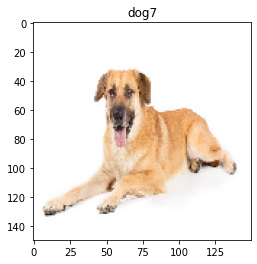

예측 결과 값: [[0.9278758]]
개 종류 예측: [('n02099601', 'golden_retriever', 0.1444673), ('n02111129', 'Leonberg', 0.14269204), ('n02090721', 'Irish_wolfhound', 0.11765882)]


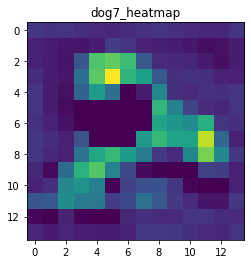

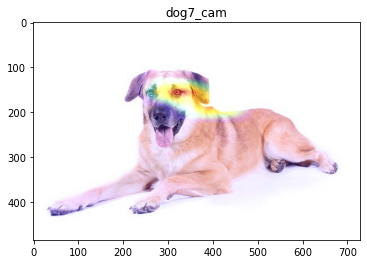

In [72]:
# dog 7

# 원본 이미지 로드
img_path = './datasets/cats_and_dogs_small/test/dog7.jpg'

# 이미지 prediction
img1 = image.load_img(img_path, target_size=(150, 150))
img_tensor1 = image.img_to_array(img1)
img_tensor1 = np.expand_dims(img_tensor1, axis=0)
img_tensor1 /= 255.

prediction1 = model.predict(img_tensor1)

# 개 종류 prediction
img2 = image.load_img(img_path, target_size=(224, 224))
img_tensor2 = image.img_to_array(img2)
img_tensor2 = np.expand_dims(img_tensor2, axis=0)
img_tensor2 = preprocess_input(img_tensor2)

prediction2 = modelVGG.predict(img_tensor2)

# heatmap을 위한 Grad-CAM 알고리즘 설정
dog_output = modelVGG.output[:, np.argmax(prediction2[0])]

last_conv_layer = modelVGG.get_layer('block5_conv3')

grads = K.gradients(dog_output, last_conv_layer.output)[0]

pooled_grads = K.mean(grads, axis=(0, 1, 2))

iterate = K.function([modelVGG.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([img_tensor2])

for i in range(0, 512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap1 = np.mean(conv_layer_output_value, axis=-1)

# heatmap 후처리
heatmap1 = np.maximum(heatmap1, 0)
heatmap1 /= np.max(heatmap1)

# 원본 이미지에 heatmap 추가
img = cv2.imread(img_path)

heatmap2 = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap2 = np.uint8(255 * heatmap2)
heatmap2 = cv2.applyColorMap(heatmap2, cv2.COLORMAP_JET)

superimposed_img = heatmap2 * 0.4 + img

cv2.imwrite('./datasets/cats_and_dogs_small/test/dog7_cam.jpg', superimposed_img)

# dog 1 결과 출력

# 원본 이미지에 heatmap 추가된 이미지 로드
img_heatmap = plt.imread('./datasets/cats_and_dogs_small/test/dog7_cam.jpg')

# 원본 이미지
plt.title('dog7')
plt.imshow(img1)
plt.show()

# 이미지 prediction
print('예측 결과 값:', prediction1)

# 개 종류 prediction
print('개 종류 예측:', decode_predictions(prediction2, top=3)[0])

# heatmap
plt.title('dog7_heatmap')
plt.imshow(heatmap1)
plt.show()

# 원본 이미지에 heatmap 추가
plt.title('dog7_cam')
plt.imshow(img_heatmap)
plt.show()

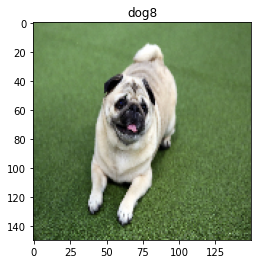

예측 결과 값: [[0.99999774]]
개 종류 예측: [('n02110958', 'pug', 0.77215886), ('n02108422', 'bull_mastiff', 0.18202601), ('n02091467', 'Norwegian_elkhound', 0.009807554)]


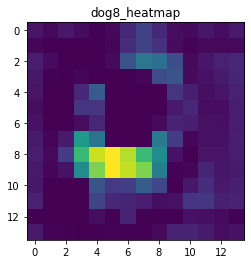

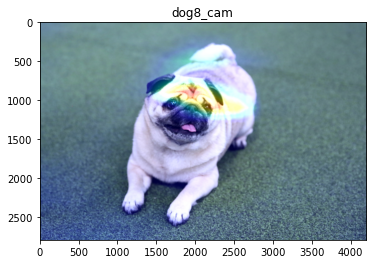

In [73]:
# dog 8

# 원본 이미지 로드
img_path = './datasets/cats_and_dogs_small/test/dog8.jpg'

# 이미지 prediction
img1 = image.load_img(img_path, target_size=(150, 150))
img_tensor1 = image.img_to_array(img1)
img_tensor1 = np.expand_dims(img_tensor1, axis=0)
img_tensor1 /= 255.

prediction1 = model.predict(img_tensor1)

# 개 종류 prediction
img2 = image.load_img(img_path, target_size=(224, 224))
img_tensor2 = image.img_to_array(img2)
img_tensor2 = np.expand_dims(img_tensor2, axis=0)
img_tensor2 = preprocess_input(img_tensor2)

prediction2 = modelVGG.predict(img_tensor2)

# heatmap을 위한 Grad-CAM 알고리즘 설정
dog_output = modelVGG.output[:, np.argmax(prediction2[0])]

last_conv_layer = modelVGG.get_layer('block5_conv3')

grads = K.gradients(dog_output, last_conv_layer.output)[0]

pooled_grads = K.mean(grads, axis=(0, 1, 2))

iterate = K.function([modelVGG.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([img_tensor2])

for i in range(0, 512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap1 = np.mean(conv_layer_output_value, axis=-1)

# heatmap 후처리
heatmap1 = np.maximum(heatmap1, 0)
heatmap1 /= np.max(heatmap1)

# 원본 이미지에 heatmap 추가
img = cv2.imread(img_path)

heatmap2 = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap2 = np.uint8(255 * heatmap2)
heatmap2 = cv2.applyColorMap(heatmap2, cv2.COLORMAP_JET)

superimposed_img = heatmap2 * 0.4 + img

cv2.imwrite('./datasets/cats_and_dogs_small/test/dog8_cam.jpg', superimposed_img)

# dog 1 결과 출력

# 원본 이미지에 heatmap 추가된 이미지 로드
img_heatmap = plt.imread('./datasets/cats_and_dogs_small/test/dog8_cam.jpg')

# 원본 이미지
plt.title('dog8')
plt.imshow(img1)
plt.show()

# 이미지 prediction
print('예측 결과 값:', prediction1)

# 개 종류 prediction
print('개 종류 예측:', decode_predictions(prediction2, top=3)[0])

# heatmap
plt.title('dog8_heatmap')
plt.imshow(heatmap1)
plt.show()

# 원본 이미지에 heatmap 추가
plt.title('dog8_cam')
plt.imshow(img_heatmap)
plt.show()

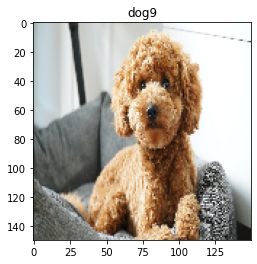

예측 결과 값: [[0.95663667]]
개 종류 예측: [('n02113712', 'miniature_poodle', 0.41973475), ('n02113624', 'toy_poodle', 0.26474914), ('n02113799', 'standard_poodle', 0.22966623)]


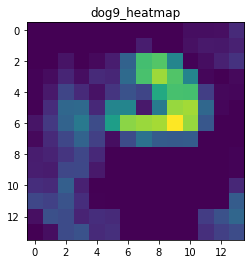

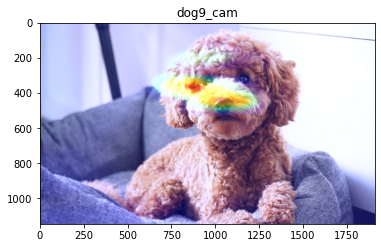

In [74]:
# dog 9

# 원본 이미지 로드
img_path = './datasets/cats_and_dogs_small/test/dog9.jpg'

# 이미지 prediction
img1 = image.load_img(img_path, target_size=(150, 150))
img_tensor1 = image.img_to_array(img1)
img_tensor1 = np.expand_dims(img_tensor1, axis=0)
img_tensor1 /= 255.

prediction1 = model.predict(img_tensor1)

# 개 종류 prediction
img2 = image.load_img(img_path, target_size=(224, 224))
img_tensor2 = image.img_to_array(img2)
img_tensor2 = np.expand_dims(img_tensor2, axis=0)
img_tensor2 = preprocess_input(img_tensor2)

prediction2 = modelVGG.predict(img_tensor2)

# heatmap을 위한 Grad-CAM 알고리즘 설정
dog_output = modelVGG.output[:, np.argmax(prediction2[0])]

last_conv_layer = modelVGG.get_layer('block5_conv3')

grads = K.gradients(dog_output, last_conv_layer.output)[0]

pooled_grads = K.mean(grads, axis=(0, 1, 2))

iterate = K.function([modelVGG.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([img_tensor2])

for i in range(0, 512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap1 = np.mean(conv_layer_output_value, axis=-1)

# heatmap 후처리
heatmap1 = np.maximum(heatmap1, 0)
heatmap1 /= np.max(heatmap1)

# 원본 이미지에 heatmap 추가
img = cv2.imread(img_path)

heatmap2 = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap2 = np.uint8(255 * heatmap2)
heatmap2 = cv2.applyColorMap(heatmap2, cv2.COLORMAP_JET)

superimposed_img = heatmap2 * 0.4 + img

cv2.imwrite('./datasets/cats_and_dogs_small/test/dog9_cam.jpg', superimposed_img)

# dog 1 결과 출력

# 원본 이미지에 heatmap 추가된 이미지 로드
img_heatmap = plt.imread('./datasets/cats_and_dogs_small/test/dog9_cam.jpg')

# 원본 이미지
plt.title('dog9')
plt.imshow(img1)
plt.show()

# 이미지 prediction
print('예측 결과 값:', prediction1)

# 개 종류 prediction
print('개 종류 예측:', decode_predictions(prediction2, top=3)[0])

# heatmap
plt.title('dog9_heatmap')
plt.imshow(heatmap1)
plt.show()

# 원본 이미지에 heatmap 추가
plt.title('dog9_cam')
plt.imshow(img_heatmap)
plt.show()

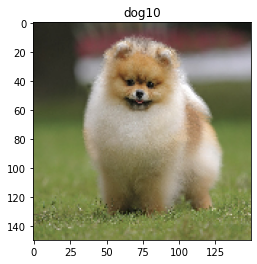

예측 결과 값: [[0.9949963]]
개 종류 예측: [('n02112018', 'Pomeranian', 0.98456526), ('n02112350', 'keeshond', 0.0063315225), ('n02112137', 'chow', 0.0020038055)]


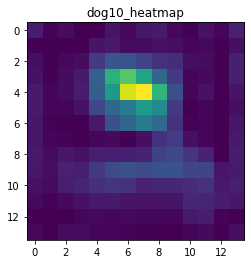

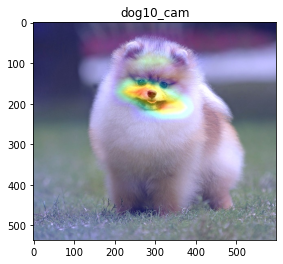

In [75]:
# dog 10

# 원본 이미지 로드
img_path = './datasets/cats_and_dogs_small/test/dog10.jpg'

# 이미지 prediction
img1 = image.load_img(img_path, target_size=(150, 150))
img_tensor1 = image.img_to_array(img1)
img_tensor1 = np.expand_dims(img_tensor1, axis=0)
img_tensor1 /= 255.

prediction1 = model.predict(img_tensor1)

# 개 종류 prediction
img2 = image.load_img(img_path, target_size=(224, 224))
img_tensor2 = image.img_to_array(img2)
img_tensor2 = np.expand_dims(img_tensor2, axis=0)
img_tensor2 = preprocess_input(img_tensor2)

prediction2 = modelVGG.predict(img_tensor2)

# heatmap을 위한 Grad-CAM 알고리즘 설정
dog_output = modelVGG.output[:, np.argmax(prediction2[0])]

last_conv_layer = modelVGG.get_layer('block5_conv3')

grads = K.gradients(dog_output, last_conv_layer.output)[0]

pooled_grads = K.mean(grads, axis=(0, 1, 2))

iterate = K.function([modelVGG.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([img_tensor2])

for i in range(0, 512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap1 = np.mean(conv_layer_output_value, axis=-1)

# heatmap 후처리
heatmap1 = np.maximum(heatmap1, 0)
heatmap1 /= np.max(heatmap1)

# 원본 이미지에 heatmap 추가
img = cv2.imread(img_path)

heatmap2 = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap2 = np.uint8(255 * heatmap2)
heatmap2 = cv2.applyColorMap(heatmap2, cv2.COLORMAP_JET)

superimposed_img = heatmap2 * 0.4 + img

cv2.imwrite('./datasets/cats_and_dogs_small/test/dog10_cam.jpg', superimposed_img)

# dog 1 결과 출력

# 원본 이미지에 heatmap 추가된 이미지 로드
img_heatmap = plt.imread('./datasets/cats_and_dogs_small/test/dog10_cam.jpg')

# 원본 이미지
plt.title('dog10')
plt.imshow(img1)
plt.show()

# 이미지 prediction
print('예측 결과 값:', prediction1)

# 개 종류 prediction
print('개 종류 예측:', decode_predictions(prediction2, top=3)[0])

# heatmap
plt.title('dog10_heatmap')
plt.imshow(heatmap1)
plt.show()

# 원본 이미지에 heatmap 추가
plt.title('dog10_cam')
plt.imshow(img_heatmap)
plt.show()

### 고양이

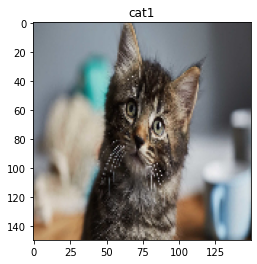

예측 결과 값: [[0.03462788]]
고양이 종류 예측: [('n02124075', 'Egyptian_cat', 0.36623797), ('n02123045', 'tabby', 0.33839574), ('n02123159', 'tiger_cat', 0.05190895)]


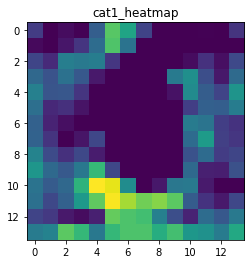

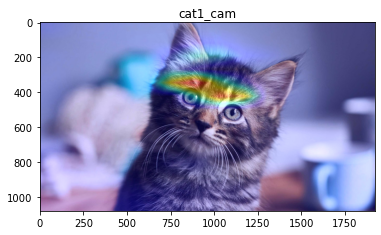

In [76]:
# cat 1

# 원본 이미지 로드
img_path = './datasets/cats_and_dogs_small/test/cat1.jpg'

# 이미지 prediction
img1 = image.load_img(img_path, target_size=(150, 150))
img_tensor1 = image.img_to_array(img1)
img_tensor1 = np.expand_dims(img_tensor1, axis=0)
img_tensor1 /= 255.

prediction1 = model.predict(img_tensor1)

# 고양이 종류 prediction
img2 = image.load_img(img_path, target_size=(224, 224))
img_tensor2 = image.img_to_array(img2)
img_tensor2 = np.expand_dims(img_tensor2, axis=0)
img_tensor2 = preprocess_input(img_tensor2)

prediction2 = modelVGG.predict(img_tensor2)

# heatmap을 위한 Grad-CAM 알고리즘 설정
dog_output = modelVGG.output[:, np.argmax(prediction2[0])]

last_conv_layer = modelVGG.get_layer('block5_conv3')

grads = K.gradients(dog_output, last_conv_layer.output)[0]

pooled_grads = K.mean(grads, axis=(0, 1, 2))

iterate = K.function([modelVGG.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([img_tensor2])

for i in range(0, 512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap1 = np.mean(conv_layer_output_value, axis=-1)

# heatmap 후처리
heatmap1 = np.maximum(heatmap1, 0)
heatmap1 /= np.max(heatmap1)

# 원본 이미지에 heatmap 추가
img = cv2.imread(img_path)

heatmap2 = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap2 = np.uint8(255 * heatmap2)
heatmap2 = cv2.applyColorMap(heatmap2, cv2.COLORMAP_JET)

superimposed_img = heatmap2 * 0.4 + img

cv2.imwrite('./datasets/cats_and_dogs_small/test/cat1_cam.jpg', superimposed_img)

# dog 1 결과 출력

# 원본 이미지에 heatmap 추가된 이미지 로드
img_heatmap = plt.imread('./datasets/cats_and_dogs_small/test/cat1_cam.jpg')

# 원본 이미지
plt.title('cat1')
plt.imshow(img1)
plt.show()

# 이미지 prediction
print('예측 결과 값:', prediction1)

# 고양이 종류 prediction
print('고양이 종류 예측:', decode_predictions(prediction2, top=3)[0])

# heatmap
plt.title('cat1_heatmap')
plt.imshow(heatmap1)
plt.show()

# 원본 이미지에 heatmap 추가
plt.title('cat1_cam')
plt.imshow(img_heatmap)
plt.show()

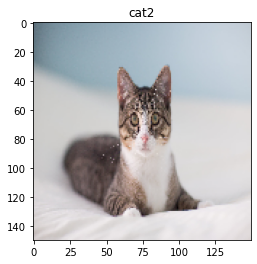

예측 결과 값: [[0.02111833]]
고양이 종류 예측: [('n02124075', 'Egyptian_cat', 0.5147486), ('n02123045', 'tabby', 0.18849786), ('n02123159', 'tiger_cat', 0.044973336)]


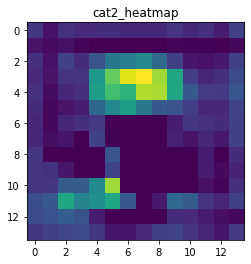

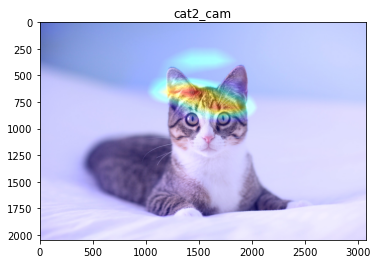

In [77]:
# cat 2

# 원본 이미지 로드
img_path = './datasets/cats_and_dogs_small/test/cat2.jpg'

# 이미지 prediction
img1 = image.load_img(img_path, target_size=(150, 150))
img_tensor1 = image.img_to_array(img1)
img_tensor1 = np.expand_dims(img_tensor1, axis=0)
img_tensor1 /= 255.

prediction1 = model.predict(img_tensor1)

# 고양이 종류 prediction
img2 = image.load_img(img_path, target_size=(224, 224))
img_tensor2 = image.img_to_array(img2)
img_tensor2 = np.expand_dims(img_tensor2, axis=0)
img_tensor2 = preprocess_input(img_tensor2)

prediction2 = modelVGG.predict(img_tensor2)

# heatmap을 위한 Grad-CAM 알고리즘 설정
dog_output = modelVGG.output[:, np.argmax(prediction2[0])]

last_conv_layer = modelVGG.get_layer('block5_conv3')

grads = K.gradients(dog_output, last_conv_layer.output)[0]

pooled_grads = K.mean(grads, axis=(0, 1, 2))

iterate = K.function([modelVGG.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([img_tensor2])

for i in range(0, 512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap1 = np.mean(conv_layer_output_value, axis=-1)

# heatmap 후처리
heatmap1 = np.maximum(heatmap1, 0)
heatmap1 /= np.max(heatmap1)

# 원본 이미지에 heatmap 추가
img = cv2.imread(img_path)

heatmap2 = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap2 = np.uint8(255 * heatmap2)
heatmap2 = cv2.applyColorMap(heatmap2, cv2.COLORMAP_JET)

superimposed_img = heatmap2 * 0.4 + img

cv2.imwrite('./datasets/cats_and_dogs_small/test/cat2_cam.jpg', superimposed_img)

# dog 1 결과 출력

# 원본 이미지에 heatmap 추가된 이미지 로드
img_heatmap = plt.imread('./datasets/cats_and_dogs_small/test/cat2_cam.jpg')

# 원본 이미지
plt.title('cat2')
plt.imshow(img1)
plt.show()

# 이미지 prediction
print('예측 결과 값:', prediction1)

# 고양이 종류 prediction
print('고양이 종류 예측:', decode_predictions(prediction2, top=3)[0])

# heatmap
plt.title('cat2_heatmap')
plt.imshow(heatmap1)
plt.show()

# 원본 이미지에 heatmap 추가
plt.title('cat2_cam')
plt.imshow(img_heatmap)
plt.show()

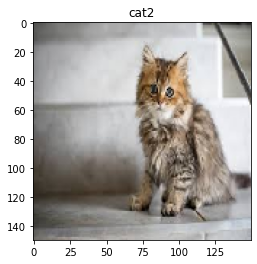

예측 결과 값: [[0.10312602]]
고양이 종류 예측: [('n02123394', 'Persian_cat', 0.60781884), ('n02123045', 'tabby', 0.2308596), ('n02123159', 'tiger_cat', 0.0949243)]


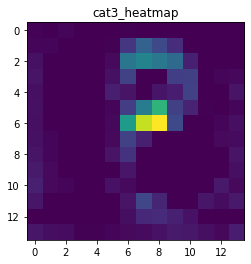

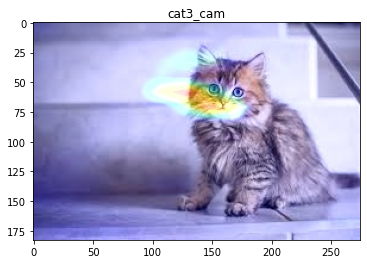

In [78]:
# cat 3

# 원본 이미지 로드
img_path = './datasets/cats_and_dogs_small/test/cat3.jpg'

# 이미지 prediction
img1 = image.load_img(img_path, target_size=(150, 150))
img_tensor1 = image.img_to_array(img1)
img_tensor1 = np.expand_dims(img_tensor1, axis=0)
img_tensor1 /= 255.

prediction1 = model.predict(img_tensor1)

# 고양이 종류 prediction
img2 = image.load_img(img_path, target_size=(224, 224))
img_tensor2 = image.img_to_array(img2)
img_tensor2 = np.expand_dims(img_tensor2, axis=0)
img_tensor2 = preprocess_input(img_tensor2)

prediction2 = modelVGG.predict(img_tensor2)

# heatmap을 위한 Grad-CAM 알고리즘 설정
dog_output = modelVGG.output[:, np.argmax(prediction2[0])]

last_conv_layer = modelVGG.get_layer('block5_conv3')

grads = K.gradients(dog_output, last_conv_layer.output)[0]

pooled_grads = K.mean(grads, axis=(0, 1, 2))

iterate = K.function([modelVGG.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([img_tensor2])

for i in range(0, 512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap1 = np.mean(conv_layer_output_value, axis=-1)

# heatmap 후처리
heatmap1 = np.maximum(heatmap1, 0)
heatmap1 /= np.max(heatmap1)

# 원본 이미지에 heatmap 추가
img = cv2.imread(img_path)

heatmap2 = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap2 = np.uint8(255 * heatmap2)
heatmap2 = cv2.applyColorMap(heatmap2, cv2.COLORMAP_JET)

superimposed_img = heatmap2 * 0.4 + img

cv2.imwrite('./datasets/cats_and_dogs_small/test/cat3_cam.jpg', superimposed_img)

# dog 1 결과 출력

# 원본 이미지에 heatmap 추가된 이미지 로드
img_heatmap = plt.imread('./datasets/cats_and_dogs_small/test/cat3_cam.jpg')

# 원본 이미지
plt.title('cat2')
plt.imshow(img1)
plt.show()

# 이미지 prediction
print('예측 결과 값:', prediction1)

# 고양이 종류 prediction
print('고양이 종류 예측:', decode_predictions(prediction2, top=3)[0])

# heatmap
plt.title('cat3_heatmap')
plt.imshow(heatmap1)
plt.show()

# 원본 이미지에 heatmap 추가
plt.title('cat3_cam')
plt.imshow(img_heatmap)
plt.show()

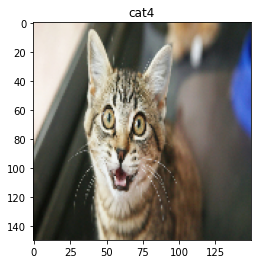

예측 결과 값: [[0.05470848]]
고양이 종류 예측: [('n02124075', 'Egyptian_cat', 0.43161732), ('n02123159', 'tiger_cat', 0.30157045), ('n02123045', 'tabby', 0.17773543)]


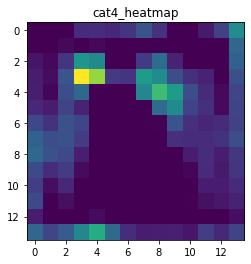

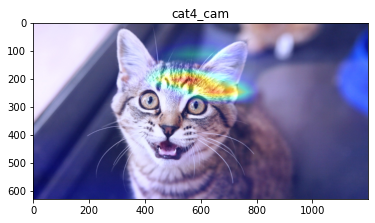

In [79]:
# cat 4

# 원본 이미지 로드
img_path = './datasets/cats_and_dogs_small/test/cat4.jpg'

# 이미지 prediction
img1 = image.load_img(img_path, target_size=(150, 150))
img_tensor1 = image.img_to_array(img1)
img_tensor1 = np.expand_dims(img_tensor1, axis=0)
img_tensor1 /= 255.

prediction1 = model.predict(img_tensor1)

# 고양이 종류 prediction
img2 = image.load_img(img_path, target_size=(224, 224))
img_tensor2 = image.img_to_array(img2)
img_tensor2 = np.expand_dims(img_tensor2, axis=0)
img_tensor2 = preprocess_input(img_tensor2)

prediction2 = modelVGG.predict(img_tensor2)

# heatmap을 위한 Grad-CAM 알고리즘 설정
dog_output = modelVGG.output[:, np.argmax(prediction2[0])]

last_conv_layer = modelVGG.get_layer('block5_conv3')

grads = K.gradients(dog_output, last_conv_layer.output)[0]

pooled_grads = K.mean(grads, axis=(0, 1, 2))

iterate = K.function([modelVGG.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([img_tensor2])

for i in range(0, 512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap1 = np.mean(conv_layer_output_value, axis=-1)

# heatmap 후처리
heatmap1 = np.maximum(heatmap1, 0)
heatmap1 /= np.max(heatmap1)

# 원본 이미지에 heatmap 추가
img = cv2.imread(img_path)

heatmap2 = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap2 = np.uint8(255 * heatmap2)
heatmap2 = cv2.applyColorMap(heatmap2, cv2.COLORMAP_JET)

superimposed_img = heatmap2 * 0.4 + img

cv2.imwrite('./datasets/cats_and_dogs_small/test/cat4_cam.jpg', superimposed_img)

# dog 1 결과 출력

# 원본 이미지에 heatmap 추가된 이미지 로드
img_heatmap = plt.imread('./datasets/cats_and_dogs_small/test/cat4_cam.jpg')

# 원본 이미지
plt.title('cat4')
plt.imshow(img1)
plt.show()

# 이미지 prediction
print('예측 결과 값:', prediction1)

# 고양이 종류 prediction
print('고양이 종류 예측:', decode_predictions(prediction2, top=3)[0])

# heatmap
plt.title('cat4_heatmap')
plt.imshow(heatmap1)
plt.show()

# 원본 이미지에 heatmap 추가
plt.title('cat4_cam')
plt.imshow(img_heatmap)
plt.show()

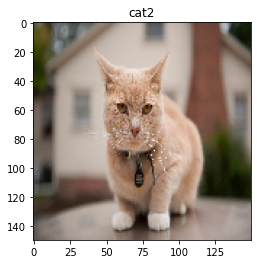

예측 결과 값: [[0.12647735]]
고양이 종류 예측: [('n02124075', 'Egyptian_cat', 0.6562711), ('n02123045', 'tabby', 0.08357798), ('n02127052', 'lynx', 0.07661951)]


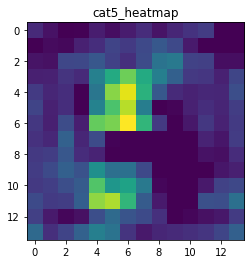

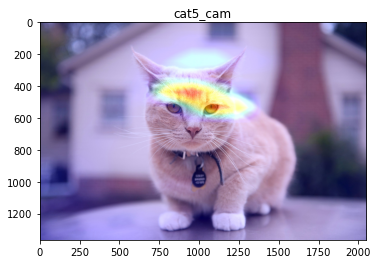

In [80]:
# cat 5

# 원본 이미지 로드
img_path = './datasets/cats_and_dogs_small/test/cat5.jpg'

# 이미지 prediction
img1 = image.load_img(img_path, target_size=(150, 150))
img_tensor1 = image.img_to_array(img1)
img_tensor1 = np.expand_dims(img_tensor1, axis=0)
img_tensor1 /= 255.

prediction1 = model.predict(img_tensor1)

# 고양이 종류 prediction
img2 = image.load_img(img_path, target_size=(224, 224))
img_tensor2 = image.img_to_array(img2)
img_tensor2 = np.expand_dims(img_tensor2, axis=0)
img_tensor2 = preprocess_input(img_tensor2)

prediction2 = modelVGG.predict(img_tensor2)

# heatmap을 위한 Grad-CAM 알고리즘 설정
dog_output = modelVGG.output[:, np.argmax(prediction2[0])]

last_conv_layer = modelVGG.get_layer('block5_conv3')

grads = K.gradients(dog_output, last_conv_layer.output)[0]

pooled_grads = K.mean(grads, axis=(0, 1, 2))

iterate = K.function([modelVGG.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([img_tensor2])

for i in range(0, 512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap1 = np.mean(conv_layer_output_value, axis=-1)

# heatmap 후처리
heatmap1 = np.maximum(heatmap1, 0)
heatmap1 /= np.max(heatmap1)

# 원본 이미지에 heatmap 추가
img = cv2.imread(img_path)

heatmap2 = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap2 = np.uint8(255 * heatmap2)
heatmap2 = cv2.applyColorMap(heatmap2, cv2.COLORMAP_JET)

superimposed_img = heatmap2 * 0.4 + img

cv2.imwrite('./datasets/cats_and_dogs_small/test/cat5_cam.jpg', superimposed_img)

# dog 1 결과 출력

# 원본 이미지에 heatmap 추가된 이미지 로드
img_heatmap = plt.imread('./datasets/cats_and_dogs_small/test/cat5_cam.jpg')

# 원본 이미지
plt.title('cat2')
plt.imshow(img1)
plt.show()

# 이미지 prediction
print('예측 결과 값:', prediction1)

# 고양이 종류 prediction
print('고양이 종류 예측:', decode_predictions(prediction2, top=3)[0])

# heatmap
plt.title('cat5_heatmap')
plt.imshow(heatmap1)
plt.show()

# 원본 이미지에 heatmap 추가
plt.title('cat5_cam')
plt.imshow(img_heatmap)
plt.show()

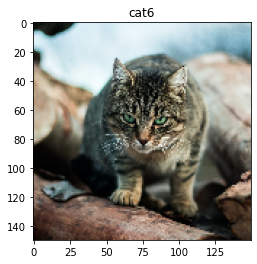

예측 결과 값: [[0.20356545]]
고양이 종류 예측: [('n02127052', 'lynx', 0.316218), ('n02124075', 'Egyptian_cat', 0.24666499), ('n02123045', 'tabby', 0.21020369)]


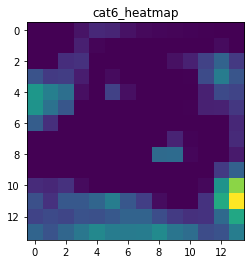

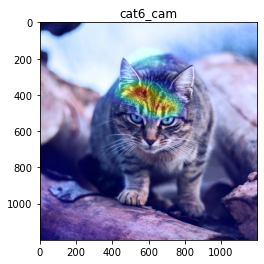

In [81]:
# cat 6

# 원본 이미지 로드
img_path = './datasets/cats_and_dogs_small/test/cat6.jpg'

# 이미지 prediction
img1 = image.load_img(img_path, target_size=(150, 150))
img_tensor1 = image.img_to_array(img1)
img_tensor1 = np.expand_dims(img_tensor1, axis=0)
img_tensor1 /= 255.

prediction1 = model.predict(img_tensor1)

# 고양이 종류 prediction
img2 = image.load_img(img_path, target_size=(224, 224))
img_tensor2 = image.img_to_array(img2)
img_tensor2 = np.expand_dims(img_tensor2, axis=0)
img_tensor2 = preprocess_input(img_tensor2)

prediction2 = modelVGG.predict(img_tensor2)

# heatmap을 위한 Grad-CAM 알고리즘 설정
dog_output = modelVGG.output[:, np.argmax(prediction2[0])]

last_conv_layer = modelVGG.get_layer('block5_conv3')

grads = K.gradients(dog_output, last_conv_layer.output)[0]

pooled_grads = K.mean(grads, axis=(0, 1, 2))

iterate = K.function([modelVGG.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([img_tensor2])

for i in range(0, 512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap1 = np.mean(conv_layer_output_value, axis=-1)

# heatmap 후처리
heatmap1 = np.maximum(heatmap1, 0)
heatmap1 /= np.max(heatmap1)

# 원본 이미지에 heatmap 추가
img = cv2.imread(img_path)

heatmap2 = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap2 = np.uint8(255 * heatmap2)
heatmap2 = cv2.applyColorMap(heatmap2, cv2.COLORMAP_JET)

superimposed_img = heatmap2 * 0.4 + img

cv2.imwrite('./datasets/cats_and_dogs_small/test/cat6_cam.jpg', superimposed_img)

# dog 1 결과 출력

# 원본 이미지에 heatmap 추가된 이미지 로드
img_heatmap = plt.imread('./datasets/cats_and_dogs_small/test/cat6_cam.jpg')

# 원본 이미지
plt.title('cat6')
plt.imshow(img1)
plt.show()

# 이미지 prediction
print('예측 결과 값:', prediction1)

# 고양이 종류 prediction
print('고양이 종류 예측:', decode_predictions(prediction2, top=3)[0])

# heatmap
plt.title('cat6_heatmap')
plt.imshow(heatmap1)
plt.show()

# 원본 이미지에 heatmap 추가
plt.title('cat6_cam')
plt.imshow(img_heatmap)
plt.show()

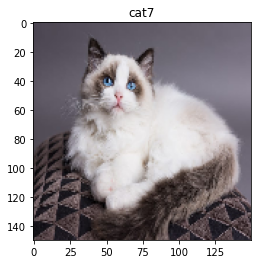

예측 결과 값: [[0.04465934]]
고양이 종류 예측: [('n02123394', 'Persian_cat', 0.7815291), ('n02127052', 'lynx', 0.061286874), ('n02124075', 'Egyptian_cat', 0.046143454)]


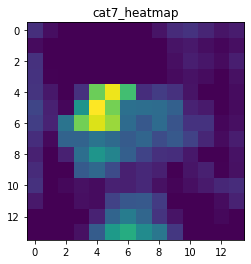

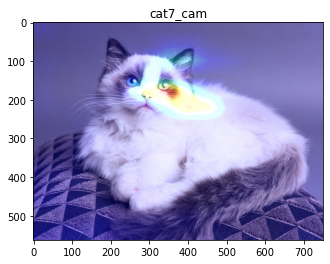

In [82]:
# cat 7

# 원본 이미지 로드
img_path = './datasets/cats_and_dogs_small/test/cat7.jpg'

# 이미지 prediction
img1 = image.load_img(img_path, target_size=(150, 150))
img_tensor1 = image.img_to_array(img1)
img_tensor1 = np.expand_dims(img_tensor1, axis=0)
img_tensor1 /= 255.

prediction1 = model.predict(img_tensor1)

# 고양이 종류 prediction
img2 = image.load_img(img_path, target_size=(224, 224))
img_tensor2 = image.img_to_array(img2)
img_tensor2 = np.expand_dims(img_tensor2, axis=0)
img_tensor2 = preprocess_input(img_tensor2)

prediction2 = modelVGG.predict(img_tensor2)

# heatmap을 위한 Grad-CAM 알고리즘 설정
dog_output = modelVGG.output[:, np.argmax(prediction2[0])]

last_conv_layer = modelVGG.get_layer('block5_conv3')

grads = K.gradients(dog_output, last_conv_layer.output)[0]

pooled_grads = K.mean(grads, axis=(0, 1, 2))

iterate = K.function([modelVGG.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([img_tensor2])

for i in range(0, 512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap1 = np.mean(conv_layer_output_value, axis=-1)

# heatmap 후처리
heatmap1 = np.maximum(heatmap1, 0)
heatmap1 /= np.max(heatmap1)

# 원본 이미지에 heatmap 추가
img = cv2.imread(img_path)

heatmap2 = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap2 = np.uint8(255 * heatmap2)
heatmap2 = cv2.applyColorMap(heatmap2, cv2.COLORMAP_JET)

superimposed_img = heatmap2 * 0.4 + img

cv2.imwrite('./datasets/cats_and_dogs_small/test/cat7_cam.jpg', superimposed_img)

# dog 1 결과 출력

# 원본 이미지에 heatmap 추가된 이미지 로드
img_heatmap = plt.imread('./datasets/cats_and_dogs_small/test/cat7_cam.jpg')

# 원본 이미지
plt.title('cat7')
plt.imshow(img1)
plt.show()

# 이미지 prediction
print('예측 결과 값:', prediction1)

# 고양이 종류 prediction
print('고양이 종류 예측:', decode_predictions(prediction2, top=3)[0])

# heatmap
plt.title('cat7_heatmap')
plt.imshow(heatmap1)
plt.show()

# 원본 이미지에 heatmap 추가
plt.title('cat7_cam')
plt.imshow(img_heatmap)
plt.show()

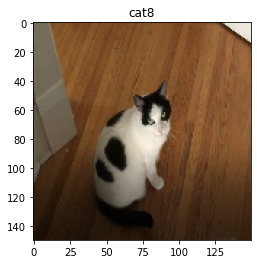

예측 결과 값: [[0.47336808]]
고양이 종류 예측: [('n15075141', 'toilet_tissue', 0.120745175), ('n02123597', 'Siamese_cat', 0.106862545), ('n04265275', 'space_heater', 0.10132045)]


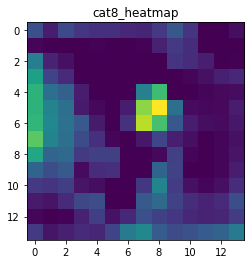

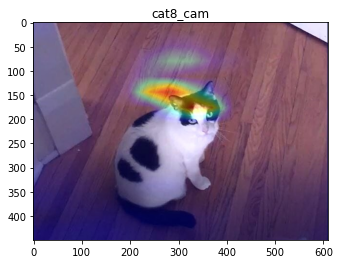

In [83]:
# cat 8

# 원본 이미지 로드
img_path = './datasets/cats_and_dogs_small/test/cat8.jpg'

# 이미지 prediction
img1 = image.load_img(img_path, target_size=(150, 150))
img_tensor1 = image.img_to_array(img1)
img_tensor1 = np.expand_dims(img_tensor1, axis=0)
img_tensor1 /= 255.

prediction1 = model.predict(img_tensor1)

# 고양이 종류 prediction
img2 = image.load_img(img_path, target_size=(224, 224))
img_tensor2 = image.img_to_array(img2)
img_tensor2 = np.expand_dims(img_tensor2, axis=0)
img_tensor2 = preprocess_input(img_tensor2)

prediction2 = modelVGG.predict(img_tensor2)

# heatmap을 위한 Grad-CAM 알고리즘 설정
dog_output = modelVGG.output[:, np.argmax(prediction2[0])]

last_conv_layer = modelVGG.get_layer('block5_conv3')

grads = K.gradients(dog_output, last_conv_layer.output)[0]

pooled_grads = K.mean(grads, axis=(0, 1, 2))

iterate = K.function([modelVGG.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([img_tensor2])

for i in range(0, 512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap1 = np.mean(conv_layer_output_value, axis=-1)

# heatmap 후처리
heatmap1 = np.maximum(heatmap1, 0)
heatmap1 /= np.max(heatmap1)

# 원본 이미지에 heatmap 추가
img = cv2.imread(img_path)

heatmap2 = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap2 = np.uint8(255 * heatmap2)
heatmap2 = cv2.applyColorMap(heatmap2, cv2.COLORMAP_JET)

superimposed_img = heatmap2 * 0.4 + img

cv2.imwrite('./datasets/cats_and_dogs_small/test/cat8_cam.jpg', superimposed_img)

# dog 1 결과 출력

# 원본 이미지에 heatmap 추가된 이미지 로드
img_heatmap = plt.imread('./datasets/cats_and_dogs_small/test/cat8_cam.jpg')

# 원본 이미지
plt.title('cat8')
plt.imshow(img1)
plt.show()

# 이미지 prediction
print('예측 결과 값:', prediction1)

# 고양이 종류 prediction
print('고양이 종류 예측:', decode_predictions(prediction2, top=3)[0])

# heatmap
plt.title('cat8_heatmap')
plt.imshow(heatmap1)
plt.show()

# 원본 이미지에 heatmap 추가
plt.title('cat8_cam')
plt.imshow(img_heatmap)
plt.show()

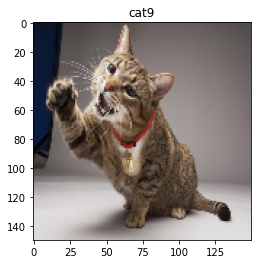

예측 결과 값: [[0.4963365]]
고양이 종류 예측: [('n02124075', 'Egyptian_cat', 0.58633727), ('n02123045', 'tabby', 0.24668151), ('n02123159', 'tiger_cat', 0.06311274)]


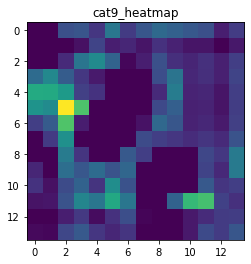

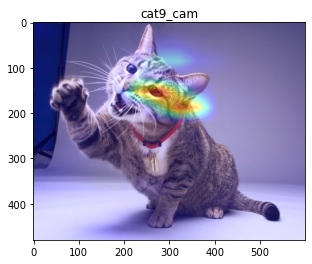

In [84]:
# cat 9

# 원본 이미지 로드
img_path = './datasets/cats_and_dogs_small/test/cat9.jpg'

# 이미지 prediction
img1 = image.load_img(img_path, target_size=(150, 150))
img_tensor1 = image.img_to_array(img1)
img_tensor1 = np.expand_dims(img_tensor1, axis=0)
img_tensor1 /= 255.

prediction1 = model.predict(img_tensor1)

# 고양이 종류 prediction
img2 = image.load_img(img_path, target_size=(224, 224))
img_tensor2 = image.img_to_array(img2)
img_tensor2 = np.expand_dims(img_tensor2, axis=0)
img_tensor2 = preprocess_input(img_tensor2)

prediction2 = modelVGG.predict(img_tensor2)

# heatmap을 위한 Grad-CAM 알고리즘 설정
dog_output = modelVGG.output[:, np.argmax(prediction2[0])]

last_conv_layer = modelVGG.get_layer('block5_conv3')

grads = K.gradients(dog_output, last_conv_layer.output)[0]

pooled_grads = K.mean(grads, axis=(0, 1, 2))

iterate = K.function([modelVGG.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([img_tensor2])

for i in range(0, 512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap1 = np.mean(conv_layer_output_value, axis=-1)

# heatmap 후처리
heatmap1 = np.maximum(heatmap1, 0)
heatmap1 /= np.max(heatmap1)

# 원본 이미지에 heatmap 추가
img = cv2.imread(img_path)

heatmap2 = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap2 = np.uint8(255 * heatmap2)
heatmap2 = cv2.applyColorMap(heatmap2, cv2.COLORMAP_JET)

superimposed_img = heatmap2 * 0.4 + img

cv2.imwrite('./datasets/cats_and_dogs_small/test/cat9_cam.jpg', superimposed_img)

# dog 1 결과 출력

# 원본 이미지에 heatmap 추가된 이미지 로드
img_heatmap = plt.imread('./datasets/cats_and_dogs_small/test/cat9_cam.jpg')

# 원본 이미지
plt.title('cat9')
plt.imshow(img1)
plt.show()

# 이미지 prediction
print('예측 결과 값:', prediction1)

# 고양이 종류 prediction
print('고양이 종류 예측:', decode_predictions(prediction2, top=3)[0])

# heatmap
plt.title('cat9_heatmap')
plt.imshow(heatmap1)
plt.show()

# 원본 이미지에 heatmap 추가
plt.title('cat9_cam')
plt.imshow(img_heatmap)
plt.show()

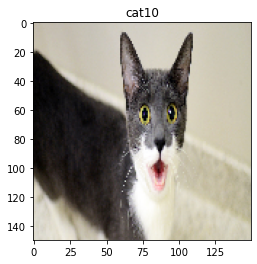

예측 결과 값: [[0.00224474]]
고양이 종류 예측: [('n02124075', 'Egyptian_cat', 0.3608017), ('n02123045', 'tabby', 0.20341331), ('n02127052', 'lynx', 0.05854661)]


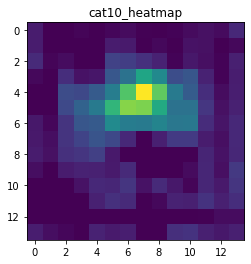

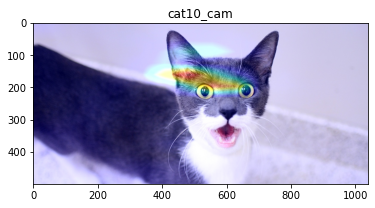

In [85]:
# cat 10

# 원본 이미지 로드
img_path = './datasets/cats_and_dogs_small/test/cat10.jpg'

# 이미지 prediction
img1 = image.load_img(img_path, target_size=(150, 150))
img_tensor1 = image.img_to_array(img1)
img_tensor1 = np.expand_dims(img_tensor1, axis=0)
img_tensor1 /= 255.

prediction1 = model.predict(img_tensor1)

# 고양이 종류 prediction
img2 = image.load_img(img_path, target_size=(224, 224))
img_tensor2 = image.img_to_array(img2)
img_tensor2 = np.expand_dims(img_tensor2, axis=0)
img_tensor2 = preprocess_input(img_tensor2)

prediction2 = modelVGG.predict(img_tensor2)

# heatmap을 위한 Grad-CAM 알고리즘 설정
dog_output = modelVGG.output[:, np.argmax(prediction2[0])]

last_conv_layer = modelVGG.get_layer('block5_conv3')

grads = K.gradients(dog_output, last_conv_layer.output)[0]

pooled_grads = K.mean(grads, axis=(0, 1, 2))

iterate = K.function([modelVGG.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([img_tensor2])

for i in range(0, 512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap1 = np.mean(conv_layer_output_value, axis=-1)

# heatmap 후처리
heatmap1 = np.maximum(heatmap1, 0)
heatmap1 /= np.max(heatmap1)

# 원본 이미지에 heatmap 추가
img = cv2.imread(img_path)

heatmap2 = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap2 = np.uint8(255 * heatmap2)
heatmap2 = cv2.applyColorMap(heatmap2, cv2.COLORMAP_JET)

superimposed_img = heatmap2 * 0.4 + img

cv2.imwrite('./datasets/cats_and_dogs_small/test/cat10_cam.jpg', superimposed_img)

# dog 1 결과 출력

# 원본 이미지에 heatmap 추가된 이미지 로드
img_heatmap = plt.imread('./datasets/cats_and_dogs_small/test/cat10_cam.jpg')

# 원본 이미지
plt.title('cat10')
plt.imshow(img1)
plt.show()

# 이미지 prediction
print('예측 결과 값:', prediction1)

# 고양이 종류 prediction
print('고양이 종류 예측:', decode_predictions(prediction2, top=3)[0])

# heatmap
plt.title('cat10_heatmap')
plt.imshow(heatmap1)
plt.show()

# 원본 이미지에 heatmap 추가
plt.title('cat10_cam')
plt.imshow(img_heatmap)
plt.show()

## 1-3. 실습을 통한 이해 및 개선 방안
        
    예측 결과 값이 0에 가까울수록 cat으로, 1에 가까울수록 dog로 predict된 것이다. 개의 경우, 10개 이미지 모두 0.75 이상의 값이 산출됐다. 이는 개로 예측이 잘 이루어졌다고 해석 가능하다. 개 종류 예측도 대체로 일치했다. 반면 고양이의 경우, 8개 이미지에서 0.1 이하의 값이 나왔지만 2개 이미지에서 0.47, 0.49의 값이 나타났다. 고양이로 예측이 대부분 잘 이루어지나, 개보다는 정확도가 낮다는 걸 확인할 수 있다. 한편, 고양이 종류 예측은 개의 경우와 비슷하게 대체로 일치했다.
    
    원본 이미지에 heatmap이 추가된 dog_cam 또는 cat_cam 이미지를 보면 개는 미간이나 코 부분에 강조가, 고양이는 머리 무늬나 수염 부분에 강조가 된 것을 볼 수 있다. 이는 모델이 개와 고양이를 구분할 때에 어떤 특징을 주로 사용하는지 알 수 있는 지표이다.

## 1-4. 결론

    각 10장씩, 총 20장의 개와 고양이 이미지를 예측했다. 개의 경우 예측이 잘 되었지만, 고양이의 경우 일부 이미지에 예측이 잘 되지 않았다. 직접 정의한 cats_and_dogs_small_2 모델의 정확도가 VGG16 모델만큼 높았다면 지금보다 예측 결과가 더 좋았을 것이다. 개, 고양이 종류 예측에서는 VGG16 모델을 이용했기에 예상대로 잘 진행됐다. 또한, 원본 이미지에 heatmap이 추가된 이미지를 통해 모델이 어떤 특징을 바탕으로 개인지 고양이인지 구분하는지 확인할 수 있었다.

<br/>

# Conv2D Filter Visualization

## 2-1. 실습문제 풀이방법

    실습에서 사용한 모델의 합성곱 기반 마지막 층은 conv2d_12이다. 해당 층을 기준으로 전체 filter 시각화를 진행했다.

## 2-2. 문서화된 소스코드 및 실행 결과

In [7]:
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

# loss tensor 정의
layer_name = 'conv2d_12'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

# input에 대한 loss gradient 계산
grads = K.gradients(loss, model.input)[0]

# gradient 정규화
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

# input 값에 대한 numpy output 값 추출
iterate = K.function([model.input], [loss, grads])

loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

# 확률적 경사 상승법을 사용한 loss 최대화
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

step = 1.
for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    
    input_img_data += grads_value * step

In [8]:
# tensor를 image 형태로 변환하기 위한 유틸리티 함수 정의

def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    
    x += 0.5
    x = np.clip(x, 0, 1)
    
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    
    return x

In [9]:
# 필터 시각화 image 만드는 함수 정의

def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    
    grads = K.gradients(loss, model.input)[0]
    
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    
    iterate = K.function([model.input], [loss, grads])
    
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])

        input_img_data += grads_value * step
    
    img = input_img_data[0]
    
    return deprocess_image(img)

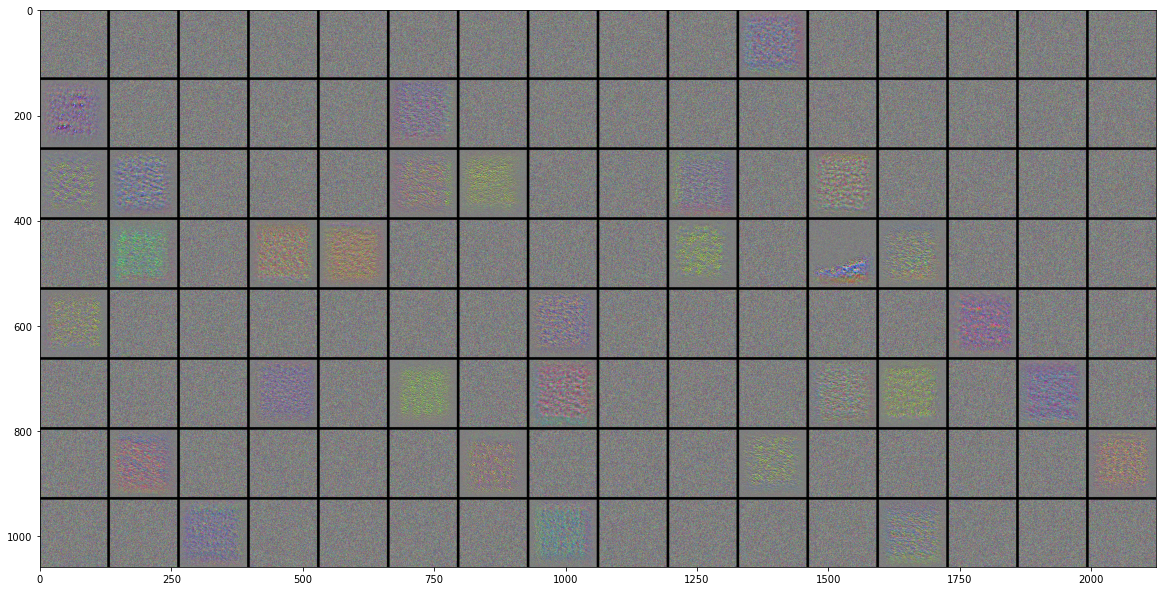

In [10]:
# conv2d_12 filter 시각화

# conv2d_12에 있는 각 filter에 반응하는 pattern 생성

layer_name = 'conv2d_12'
size = 128
margin = 5

# 8 * 16 = 128
# 64 * 2 = 128
results = np.zeros((8 * size + 7 * margin, 16 * size + 15 * margin, 3), dtype='uint8')

for i in range(0, 8):
    for j in range(0, 16):
        filter_img = generate_pattern(layer_name, (i * 16) + j, size=size)
        
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        
        results[horizontal_start:horizontal_end, vertical_start:vertical_end, :] = filter_img

plt.figure(figsize=(20, 20))
plt.imshow(results)
plt.show()

## 2-3. 실습을 통한 이해 및 개선 방안

    교재 모델의 conv2d_4는 총 64개의 filter를 가지고 있어 8*8 크기의 그리드에 결과를 저장한 반면, 실습 모델의 conv2d_12는 총 128개의 filter를 가지고 있어 8*16 크기의 그리드에 결과를 저장했다. 이에 따라, for문의 반복 횟수와 generate_pattern 함수의 매개변수 값이 달라졌다. 가로로 긴 형태의 8*16 크기의 그리드를 출력하기 전에 세로로 긴 형태의 16*8 크기의 그리드를 먼저 출력해봤는데, 전자가 후자보다 보기에 편했다. 한 눈에 전체 filter 시각화를 확인할 수 있는 형태를 구성하는 게 중요하다고 생각이 들어, 최종적으로 8*16 크기의 그리드를 이용했다.

## 2-4. 결론

    특정 층의 전체 filter 시각화를 위해서 해당 층의 channel, 즉 filter 개수를 고려하고 이에 맞는 적절한 코드 수정이 필요하다. 효과적인 시각화를 위해 알맞은 크기의 그리드를 사용할 필요가 있다.